In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs


# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
               
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats
import time_of_emrgence_calc as toe
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/112568438.gadi-pbs/matplotlib-qivtkzf2 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
# Scale the client to have n workers workers
client.cluster.scale(28)
client

- State start
- Found stale lock file and directory '/jobfs/112568438.gadi-pbs/dask-scratch-space/scheduler-mys4nxps', purging
-   Scheduler at:     tcp://127.0.0.1:35857
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:34303'
-         Start Nanny at: 'tcp://127.0.0.1:35621'
-         Start Nanny at: 'tcp://127.0.0.1:43815'
-         Start Nanny at: 'tcp://127.0.0.1:38025'
-         Start Nanny at: 'tcp://127.0.0.1:38737'
-         Start Nanny at: 'tcp://127.0.0.1:43051'
-         Start Nanny at: 'tcp://127.0.0.1:38881'
-         Start Nanny at: 'tcp://127.0.0.1:34455'
-         Start Nanny at: 'tcp://127.0.0.1:45093'
-         Start Nanny at: 'tcp://127.0.0.1:42001'
-         Start Nanny at: 'tcp://127.0.0.1:42361'
-         Start Nanny at: 'tcp://127.0.0.1:34661'
-         Start Nanny at: 'tcp://127.0.0.1:44895'
-         Start Nanny at: 'tcp://127.0.0.1:38329'
-         Start Nanny at: 'tcp://127.0.0.1:43799

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35857,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:41775,Total threads: 1
Dashboard: /proxy/43845/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:34303,


In [3]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [4]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [5]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

0.3.0


In [6]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [7]:
base_period_ds_count = base_period_ds.count(dim='time')

In [8]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [9]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

# Testing Methods

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [10]:
# best_ds = best_ds.sel(lat=slice(-45, -35), lon=slice(135, 160))

In [11]:
# Try with a belt latittude and longitude
# base_period_ds = base_period_ds.sel(lat=slice(-45, -35), lon=slice(135, 160))

In [12]:
window=20

In [13]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':25, 'time':-1}
# {'lat':5, 'lon':5, 'time':-1}

In [14]:
best_ds = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).persist()

In [15]:
best_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)>
dask.array<xarray-<this-array>, shape=(175, 180, 360), dtype=float32, chunksize=(175, 60, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [16]:
%%time
stats_test_1d_array_ttest = partial(toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

ufunc_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims=[['time']], 
    #exclude_dims={'time'},
    vectorize=True,
    output_dtypes=float, 
    dask='parallelized')

ttest_1d_ds_subset = xr.apply_ufunc(
    stats_test_1d_array_ttest,
    best_ds,
    **ufunc_kwargs).compute()

CPU times: user 1min 20s, sys: 13.4 s, total: 1min 34s
Wall time: 6min 12s


In [24]:
# The time is at the start for this calc, whilst for the rolling window it is centered.
time_1d = ttest_1d_ds_subset.time.values
half_window = int(np.ceil(window/2))

In [25]:
ttest_1d_ds_subset = ttest_1d_ds_subset.dropna(dim='time')
ttest_1d_ds_subset['time'] = time_1d[half_window:-half_window]

In [26]:
best_ds_window = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rolling(time=window, center=True, min_periods=window).construct('window_dim').persist() 
base_period_window_ds = base_period_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rename({'time':'window_dim'}).persist()

In [27]:
best_ds.shape

(175, 180, 360)

In [28]:
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [29]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 1min 45s, sys: 15 s, total: 2min
Wall time: 7min 29s


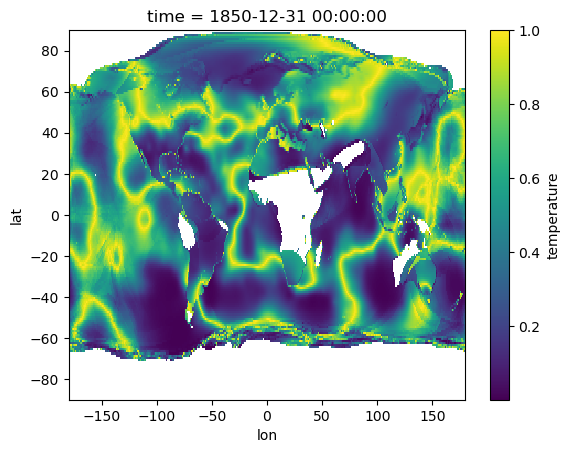

In [33]:
ttest_ds.isel(time=0).plot()

In [37]:
lat_lon_sp = dict(lat=-39, lon=145, method='nearest')

In [43]:
ttest_1d_1p = stats_test_1d_array_ttest(best_ds.sel(**lat_lon_sp))

In [44]:
ttest_1d_1p

array([0.33, 0.39, 0.7 , 0.93, 0.56, 0.5 , 0.58, 0.56, 0.64, 0.81, 0.93,
       0.81, 0.9 , 0.81, 0.93, 0.99, 0.83, 0.96, 0.9 , 0.82, 0.88, 0.62,
       0.69, 0.76, 0.88, 0.65, 0.48, 0.58, 0.67, 0.57, 0.48, 0.74, 0.81,
       0.94, 0.75, 0.77, 0.53, 0.53, 0.32, 0.33, 0.08, 0.03, 0.01, 0.01,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.05, 0.09, 0.12,
       0.08, 0.11, 0.13, 0.17, 0.25, 0.27, 0.31, 0.22, 0.18, 0.17, 0.12,
       0.12, 0.14, 0.19, 0.21, 0.16, 0.14, 0.04, 0.05, 0.03, 0.04, 0.05,
       0.02, 0.04, 0.01, 0.01, 0.01, 0.04, 0.04, 0.07, 0.03, 0.05, 0.06,
       0.05, 0.02, 0.04, 0.05, 0.3 , 0.31, 0.58, 0.66, 0.78, 0.92, 0.76,
       0.4 , 0.09, 0.11, 0.09, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

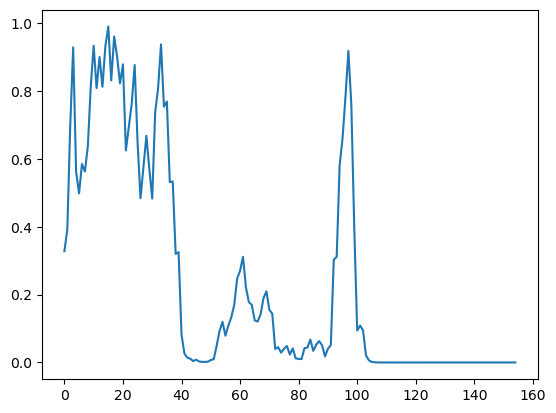

In [45]:
plt.plot(ttest_1d_1p)

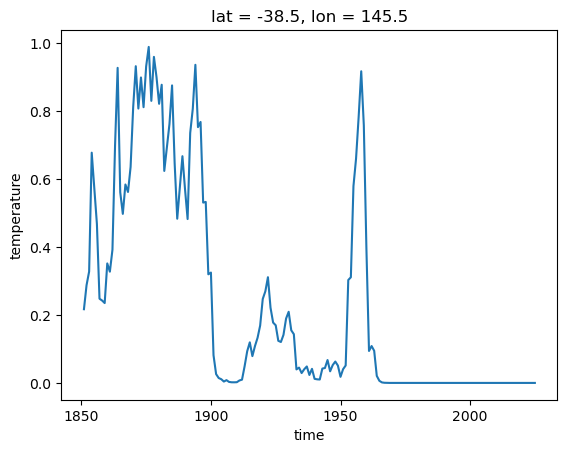

In [40]:
ttest_ds.sel(**lat_lon_sp).plot()

In [ ]:
# The xarray rolling seems to be ignoring the min periods areguement here. You can 
# see by remving the first and last 10, then it works
xr.testing.assert_allclose(ttest_ds.sel(**lat_lon_sp).isel(time=slice(10, -10)), ttest_1d_ds_subset.sel(**lat_lon_sp))

In [ ]:
# This can also be seen here.
# The smallest it goes down to is 10 years.
# So slice(0, 10) will be equal to the 0th value, slice(0, 11) will be the first value etc.
# This is confirmed here.
toe.return_ttest_pvalue(
    best_ds.sel(**lat_lon_sp).isel(time=slice(0, 12)), # The first 12 year
    best_ds.sel(**lat_lon_sp).isel(time=slice(0, 50)) # The base period
)

In [ ]:
ttest_ds.sel(**lat_lon_sp).isel(time=slice(0, 5)).values

In [ ]:
ttest_ds.sel(**lat_lon_sp).isel(time=slice(10, -10))

In [ ]:
ttest_1d_ds_subset.sel(**lat_lon_sp)

In [ ]:
# Can see here, that there is more points at the end and start
ttest_1d_ds_subset.sel(**lat_lon_sp).plot(label='1d', linestyle='--')
ttest_ds.sel(**lat_lon_sp).plot(label='roll', alpha=0.5)
plt.legend()

In [ ]:
ttest_1d_ds_subset.sel(**lat_lon_sp).plot(label='1d', linestyle='--')
ttest_ds.sel(**lat_lon_sp).plot(label='roll', alpha=0.5)
plt.legend()

In [ ]:
ttest_ds.sel(**lat_lon_sp).isel(time=slice(20,None))

In [ ]:
# When removing the start and the end they match perfectly now
ttest_1d_ds_subset.sel(**lat_lon_sp).plot(label='1d', linestyle='--')
ttest_ds.sel(**lat_lon_sp).isel(time=slice(10,-10)).plot(label='roll', alpha=0.5)
plt.legend()